In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data, show_sws_weights_log
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Some Tuning

In [3]:
model_kd_s, gmp_kd_s, res_kd_s = retrain_model(100, 10, 2500, 1250, 1e-6, 4, 15, "LeNet_300_100", "full", 'CEST', False, "")

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 100.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.48
Epoch: 20. Test Accuracy: 98.45
Epoch: 30. Test Accuracy: 98.45
Epoch: 40. Test Accuracy: 98.44
Epoch: 50. Test Accuracy: 98.44
Retrain Test: 98.44, Prune Test: 98.00, Prune Sparsity: 76.08


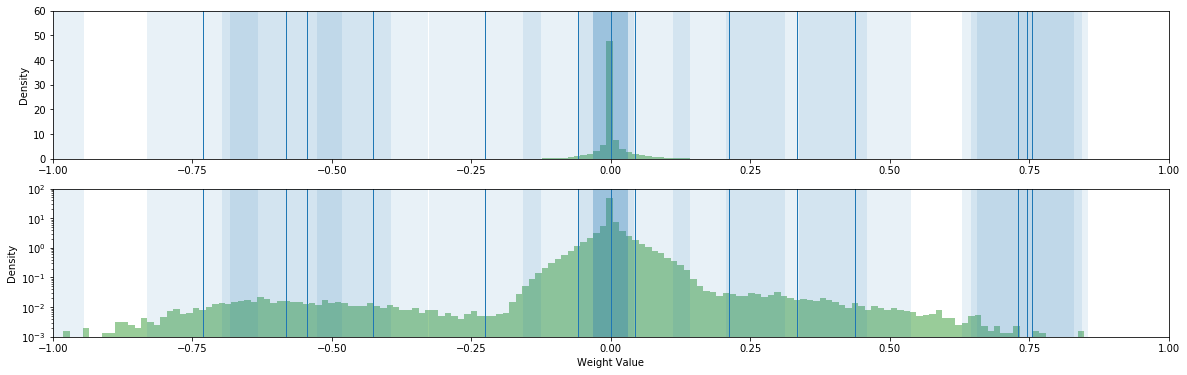

In [7]:
show_sws_weights(model = model_kd_s, means = list(gmp_kd_s.means.data.clone().cpu()), precisions = list(gmp_kd_s.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 500.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.33
Epoch: 20. Test Accuracy: 98.30
Epoch: 30. Test Accuracy: 97.48
Epoch: 40. Test Accuracy: 97.67
Epoch: 50. Test Accuracy: 97.66
Retrain Test: 97.66, Prune Test: 97.03, Prune Sparsity: 97.43


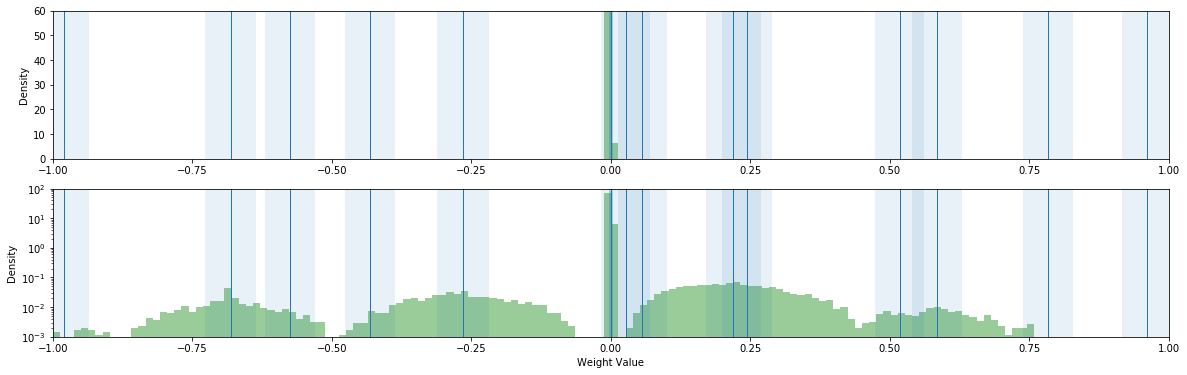

In [8]:
#increase tau, increase mean
model, gmp, res = retrain_model(500, 10, 2500, 1250, 1e-5, 4, 15, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 500.0 Variance: 10.0
Epoch: 10. Test Accuracy: 96.93
Epoch: 20. Test Accuracy: 97.40
Epoch: 30. Test Accuracy: 97.62
Epoch: 40. Test Accuracy: 97.64
Epoch: 50. Test Accuracy: 97.68
Retrain Test: 97.68, Prune Test: 97.11, Prune Sparsity: 97.06


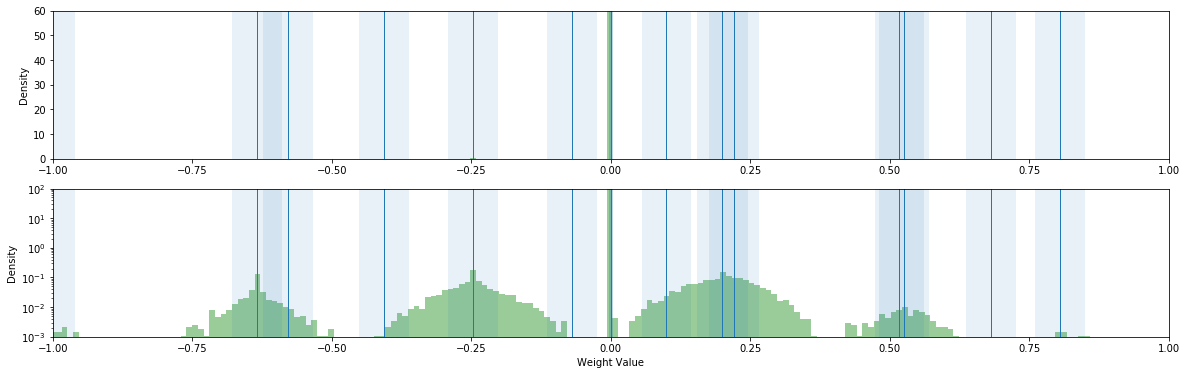

<IPython.core.display.Javascript object>

In [9]:
%%notify
#decrease temp
model, gmp, res = retrain_model(500, 10, 2500, 1250, 1e-5, 2, 15, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 1000.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.34
Epoch: 20. Test Accuracy: 98.37
Epoch: 30. Test Accuracy: 98.06
Epoch: 40. Test Accuracy: 97.76
Epoch: 50. Test Accuracy: 97.93
Retrain Test: 97.93, Prune Test: 96.95, Prune Sparsity: 96.75


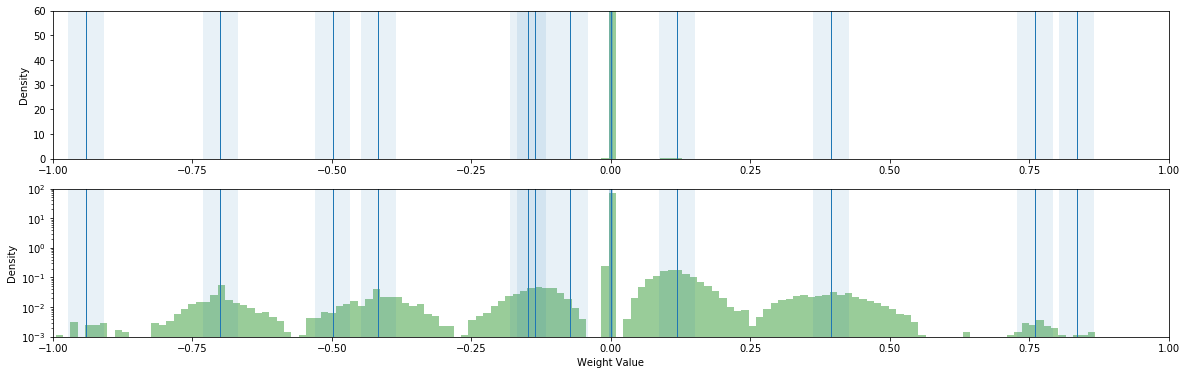

<IPython.core.display.Javascript object>

In [10]:
%%notify
#increase temp, increase mean
model, gmp, res = retrain_model(1000, 10, 2500, 1250, 1e-5, 4, 15, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 1000.0 Variance: 10.0
Epoch: 10. Test Accuracy: 92.14
Epoch: 20. Test Accuracy: 93.01
Epoch: 30. Test Accuracy: 93.25
Epoch: 40. Test Accuracy: 93.45
Epoch: 50. Test Accuracy: 93.46
Retrain Test: 93.46, Prune Test: 89.78, Prune Sparsity: 98.16


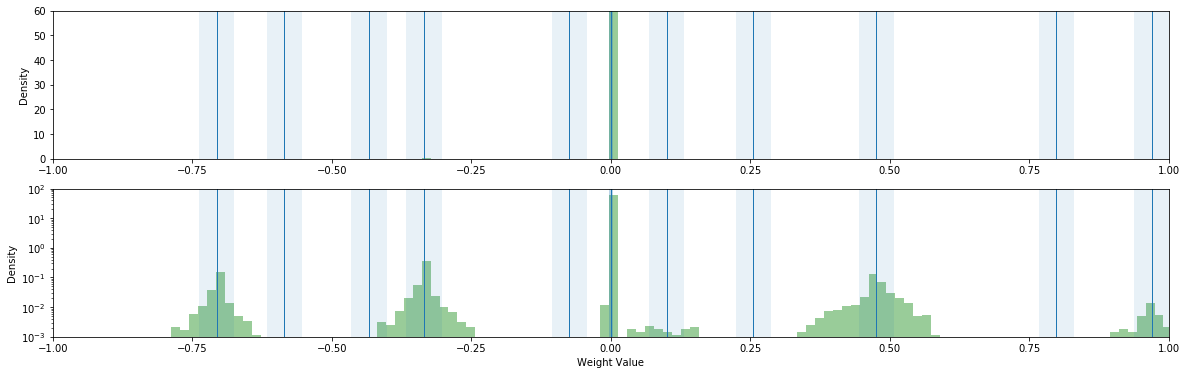

<IPython.core.display.Javascript object>

In [11]:
%%notify
#MSE
model, gmp, res = retrain_model(1000, 10, 2500, 1250, 1e-5, 4, 15, "LeNet_300_100", "full", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 1000.0 Variance: 100.0
Epoch: 10. Test Accuracy: 98.34, Prune Accuracy: 97.98, Sparsity: 66.95
Epoch: 20. Test Accuracy: 98.31, Prune Accuracy: 96.32, Sparsity: 77.65
Epoch: 30. Test Accuracy: 98.06, Prune Accuracy: 95.89, Sparsity: 90.96
Epoch: 40. Test Accuracy: 97.69, Prune Accuracy: 96.27, Sparsity: 97.06
Epoch: 50. Test Accuracy: 97.87, Prune Accuracy: 97.10, Sparsity: 97.10
Retrain Test: 97.87, Prune Test: 97.10, Prune Sparsity: 97.10


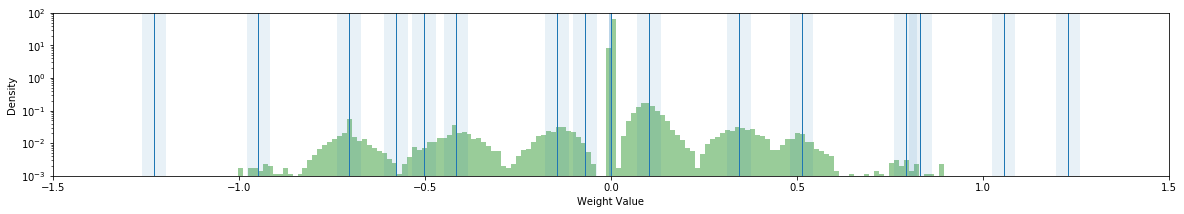

<IPython.core.display.Javascript object>

In [19]:
%%notify
#increase temp, increase mean
model, gmp, res = retrain_model(1000, 100, 2500, 1250, 1e-5, 4, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 1000.0 Variance: 100.0
Epoch: 10. Test Accuracy: 98.24, Prune Accuracy: 96.02, Sparsity: 72.46
Epoch: 20. Test Accuracy: 97.48, Prune Accuracy: 96.04, Sparsity: 97.20
Epoch: 30. Test Accuracy: 97.80, Prune Accuracy: 96.76, Sparsity: 97.22
Epoch: 40. Test Accuracy: 97.94, Prune Accuracy: 97.03, Sparsity: 97.23
Epoch: 50. Test Accuracy: 97.98, Prune Accuracy: 97.28, Sparsity: 97.23
Retrain Test: 97.98, Prune Test: 97.28, Prune Sparsity: 97.23


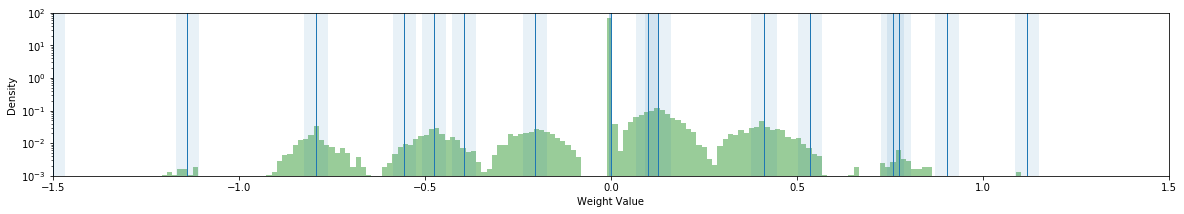

<IPython.core.display.Javascript object>

In [20]:
%%notify
#change LR - means 1e-4 to 0.5e-4, weight 1e-4 to 2e-4
model, gmp, res = retrain_model(1000, 100, 2500, 1250, 1e-5, 4, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 1000.0 Variance: 100.0
Epoch: 10. Test Accuracy: 96.02, Prune Accuracy: 94.48, Sparsity: 98.44
Epoch: 20. Test Accuracy: 96.72, Prune Accuracy: 95.64, Sparsity: 98.44
Epoch: 30. Test Accuracy: 96.89, Prune Accuracy: 96.06, Sparsity: 98.44
Epoch: 40. Test Accuracy: 96.95, Prune Accuracy: 95.94, Sparsity: 98.44
Epoch: 50. Test Accuracy: 97.11, Prune Accuracy: 96.15, Sparsity: 98.44
Retrain Test: 97.11, Prune Test: 96.15, Prune Sparsity: 98.44


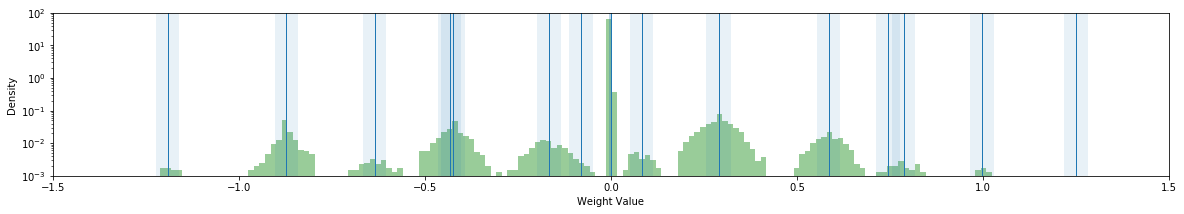

<IPython.core.display.Javascript object>

In [21]:
%%notify
#Increase tau to 3e-5
model, gmp, res = retrain_model(1000, 100, 2500, 1250, 3e-5, 4, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 1000.0 Variance: 100.0
Epoch: 10. Test Accuracy: 98.39, Prune Accuracy: 97.97, Sparsity: 64.31
Epoch: 20. Test Accuracy: 98.36, Prune Accuracy: 81.59, Sparsity: 75.71
Epoch: 30. Test Accuracy: 98.17, Prune Accuracy: 93.44, Sparsity: 84.40
Epoch: 40. Test Accuracy: 97.96, Prune Accuracy: 96.58, Sparsity: 97.23
Epoch: 50. Test Accuracy: 98.04, Prune Accuracy: 97.03, Sparsity: 97.23
Retrain Test: 98.04, Prune Test: 97.03, Prune Sparsity: 97.23


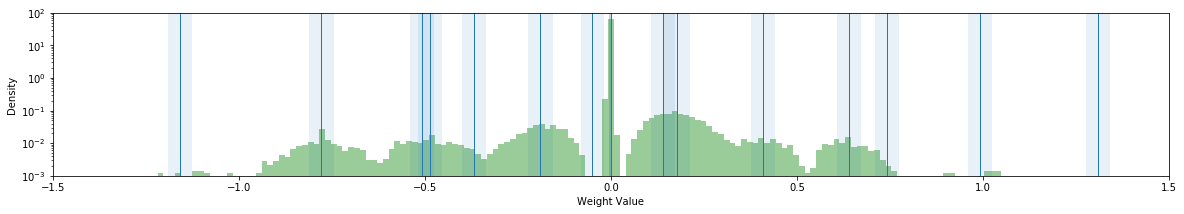

<IPython.core.display.Javascript object>

In [22]:
%%notify
#Decrease tau to 5e-6
model, gmp, res = retrain_model(1000, 100, 2500, 1250, 5e-6, 4, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 1000.0 Variance: 100.0
Epoch: 10. Test Accuracy: 98.33, Prune Accuracy: 98.10, Sparsity: 66.19
Epoch: 20. Test Accuracy: 98.23, Prune Accuracy: 94.62, Sparsity: 69.74
Epoch: 30. Test Accuracy: 97.79, Prune Accuracy: 96.73, Sparsity: 97.19
Epoch: 40. Test Accuracy: 98.05, Prune Accuracy: 97.21, Sparsity: 97.16
Epoch: 50. Test Accuracy: 98.07, Prune Accuracy: 97.42, Sparsity: 97.17
Retrain Test: 98.07, Prune Test: 97.42, Prune Sparsity: 97.17


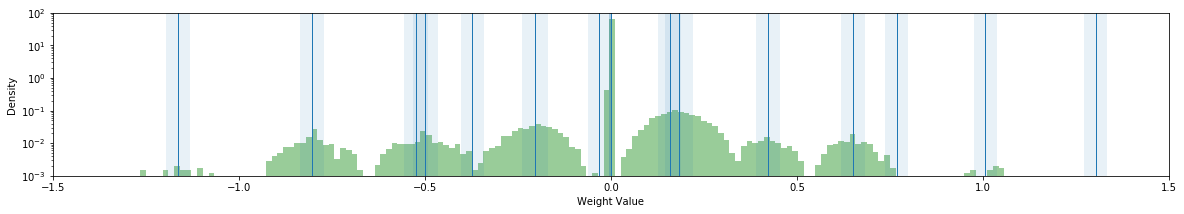

<IPython.core.display.Javascript object>

In [23]:
%%notify
#change LR - means 1e-4 to 0.5e-4, weight 1e-4 to 2e-4
model, gmp, res = retrain_model(1000, 100, 2500, 1250, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 1000.0 Variance: 100.0
Epoch: 10. Test Accuracy: 98.42, Prune Accuracy: 97.98, Sparsity: 62.69
Epoch: 20. Test Accuracy: 98.34, Prune Accuracy: 78.86, Sparsity: 75.09
Epoch: 30. Test Accuracy: 98.18, Prune Accuracy: 92.14, Sparsity: 94.93
Epoch: 40. Test Accuracy: 97.93, Prune Accuracy: 95.50, Sparsity: 97.70
Epoch: 50. Test Accuracy: 97.99, Prune Accuracy: 96.57, Sparsity: 97.70
Retrain Test: 97.99, Prune Test: 96.57, Prune Sparsity: 97.70


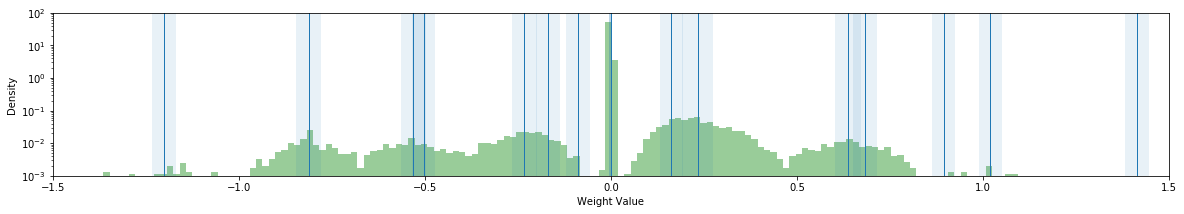

<IPython.core.display.Javascript object>

In [25]:
%%notify
#inc. temp to 6
model, gmp, res = retrain_model(1000, 100, 2500, 1250, 1e-5, 6, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.42, Prune Accuracy: 97.84, Sparsity: 66.89
Epoch: 20. Test Accuracy: 98.25, Prune Accuracy: 94.24, Sparsity: 96.60
Epoch: 30. Test Accuracy: 98.09, Prune Accuracy: 97.41, Sparsity: 97.04
Epoch: 40. Test Accuracy: 98.05, Prune Accuracy: 97.53, Sparsity: 97.04
Epoch: 50. Test Accuracy: 98.08, Prune Accuracy: 97.62, Sparsity: 97.04
Retrain Test: 98.08, Prune Test: 97.62, Prune Sparsity: 97.04


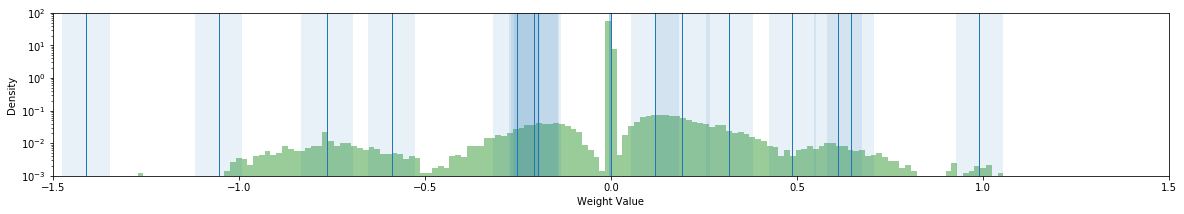

<IPython.core.display.Javascript object>

In [26]:
%%notify
#temp back to 5, decrease mean, var
model, gmp, res = retrain_model(250, 10, 2500, 1250, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.30, Prune Accuracy: 97.94, Sparsity: 66.91
Epoch: 20. Test Accuracy: 98.19, Prune Accuracy: 93.63, Sparsity: 95.49
Epoch: 30. Test Accuracy: 98.00, Prune Accuracy: 97.42, Sparsity: 97.02
Epoch: 40. Test Accuracy: 97.97, Prune Accuracy: 97.70, Sparsity: 96.98
Epoch: 50. Test Accuracy: 98.11, Prune Accuracy: 97.89, Sparsity: 96.98
Epoch: 60. Test Accuracy: 98.17, Prune Accuracy: 97.91, Sparsity: 96.99
Epoch: 70. Test Accuracy: 98.11, Prune Accuracy: 97.92, Sparsity: 96.99
Epoch: 80. Test Accuracy: 98.12, Prune Accuracy: 97.89, Sparsity: 97.01
Epoch: 90. Test Accuracy: 98.10, Prune Accuracy: 97.76, Sparsity: 97.01
Epoch: 100. Test Accuracy: 98.03, Prune Accuracy: 97.79, Sparsity: 97.01
Retrain Test: 98.03, Prune Test: 97.79, Prune Sparsity: 97.01


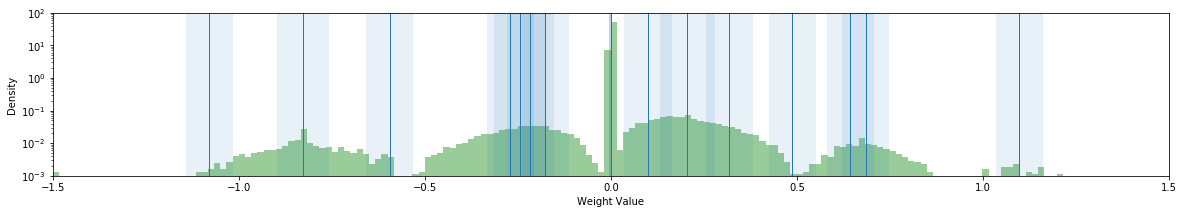

<IPython.core.display.Javascript object>

In [27]:
%%notify
#100 epochs
model, gmp, res = retrain_model(250, 10, 2500, 1250, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

### MSE

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 93.90, Prune Accuracy: 91.69, Sparsity: 99.02
Epoch: 20. Test Accuracy: 94.73, Prune Accuracy: 92.91, Sparsity: 99.02
Epoch: 30. Test Accuracy: 95.22, Prune Accuracy: 93.71, Sparsity: 99.02
Epoch: 40. Test Accuracy: 95.23, Prune Accuracy: 93.95, Sparsity: 99.02
Epoch: 50. Test Accuracy: 95.40, Prune Accuracy: 94.27, Sparsity: 99.02
Retrain Test: 95.40, Prune Test: 94.27, Prune Sparsity: 99.02


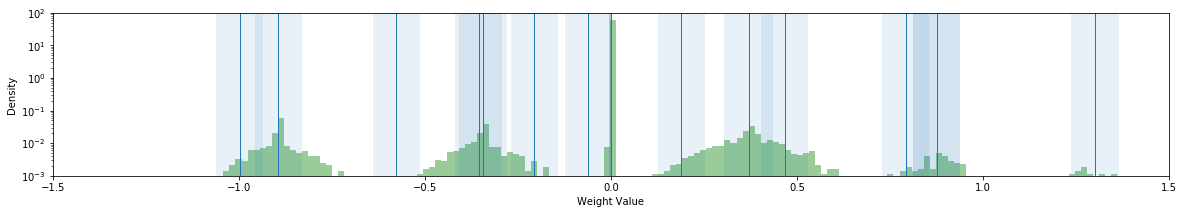

<IPython.core.display.Javascript object>

In [28]:
%%notify
#100 epochs
model, gmp, res = retrain_model(250, 10, 2500, 1250, 1e-5, 5, 16, "LeNet_300_100", "full", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 95.98, Prune Accuracy: 94.63, Sparsity: 98.39
Epoch: 20. Test Accuracy: 96.53, Prune Accuracy: 95.83, Sparsity: 98.39
Epoch: 30. Test Accuracy: 96.81, Prune Accuracy: 96.10, Sparsity: 98.39
Epoch: 40. Test Accuracy: 96.91, Prune Accuracy: 96.26, Sparsity: 98.38
Epoch: 50. Test Accuracy: 96.91, Prune Accuracy: 96.36, Sparsity: 98.38
Retrain Test: 96.91, Prune Test: 96.36, Prune Sparsity: 98.38


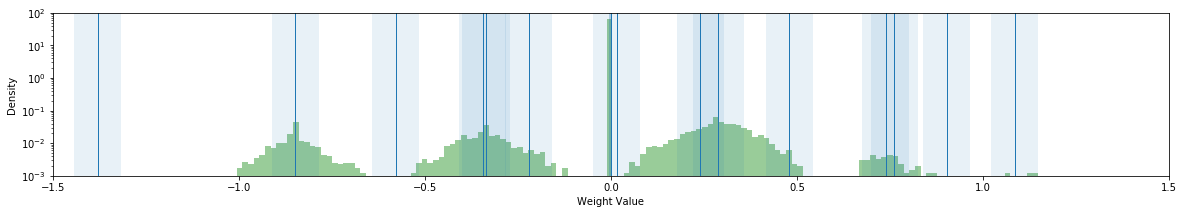

<IPython.core.display.Javascript object>

In [29]:
%%notify
#MSE
model, gmp, res = retrain_model(250, 10, 2500, 1250, 5e-6, 5, 16, "LeNet_300_100", "full", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.24, Prune Accuracy: 89.76, Sparsity: 74.10
Epoch: 20. Test Accuracy: 97.69, Prune Accuracy: 97.06, Sparsity: 92.64
Epoch: 30. Test Accuracy: 97.91, Prune Accuracy: 97.29, Sparsity: 97.20
Epoch: 40. Test Accuracy: 98.02, Prune Accuracy: 97.49, Sparsity: 97.22
Epoch: 50. Test Accuracy: 97.96, Prune Accuracy: 97.67, Sparsity: 97.24
Retrain Test: 97.96, Prune Test: 97.67, Prune Sparsity: 97.24


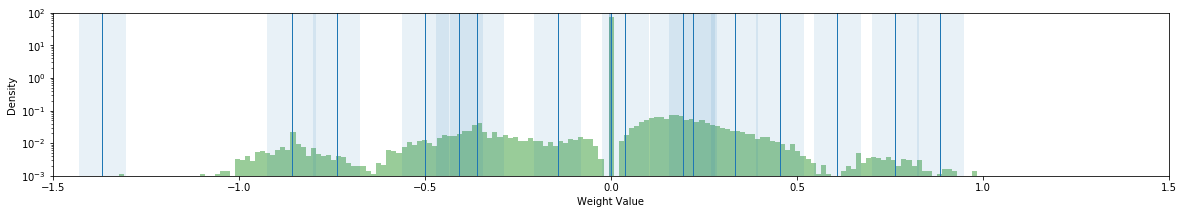

In [3]:
#tau down to 1e-6
model, gmp, res = retrain_model(250, 10, 2500, 1250, 1e-6, 5, 16, "LeNet_300_100", "full", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.21, Prune Accuracy: 96.70, Sparsity: 97.67
Epoch: 20. Test Accuracy: 97.58, Prune Accuracy: 97.43, Sparsity: 97.69
Epoch: 30. Test Accuracy: 97.76, Prune Accuracy: 97.43, Sparsity: 97.69
Epoch: 40. Test Accuracy: 97.85, Prune Accuracy: 97.63, Sparsity: 97.71
Epoch: 50. Test Accuracy: 97.76, Prune Accuracy: 97.40, Sparsity: 97.76
Retrain Test: 97.76, Prune Test: 97.40, Prune Sparsity: 97.76


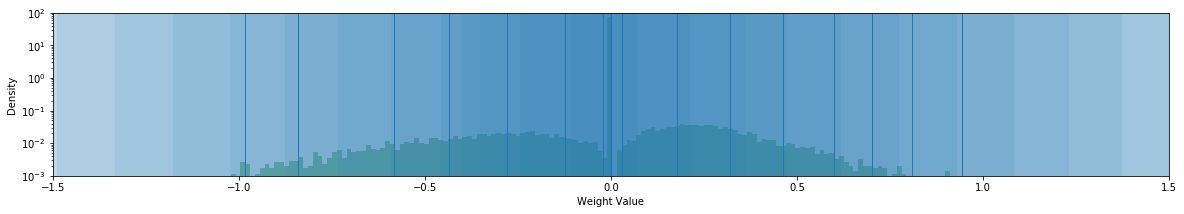

<IPython.core.display.Javascript object>

In [6]:
%%notify
### SWS check
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', False)
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.34, Prune Accuracy: 97.71, Sparsity: 86.47
Epoch: 20. Test Accuracy: 98.02, Prune Accuracy: 97.78, Sparsity: 96.12
Epoch: 30. Test Accuracy: 98.09, Prune Accuracy: 97.81, Sparsity: 96.09
Epoch: 40. Test Accuracy: 98.12, Prune Accuracy: 97.83, Sparsity: 94.91
Epoch: 50. Test Accuracy: 98.12, Prune Accuracy: 97.92, Sparsity: 93.93
Retrain Test: 98.12, Prune Test: 97.92, Prune Sparsity: 93.93


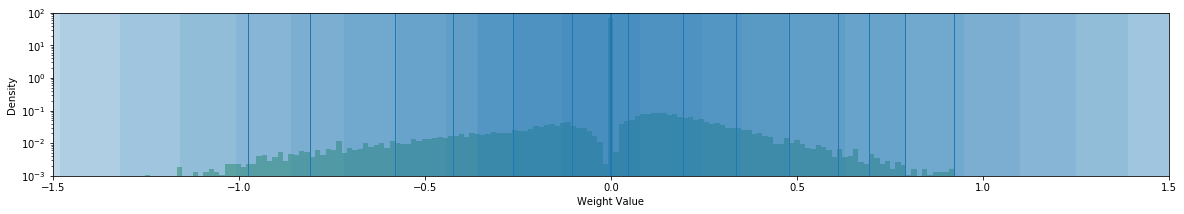

<IPython.core.display.Javascript object>

In [5]:
%%notify
### SWS check
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, 5, 16, "LeNet_300_100", "full", 'MSEST', False)
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.45, Prune Accuracy: 98.34, Sparsity: 60.82
Epoch: 20. Test Accuracy: 98.49, Prune Accuracy: 98.34, Sparsity: 69.05
Epoch: 30. Test Accuracy: 98.44, Prune Accuracy: 98.30, Sparsity: 75.18
Epoch: 40. Test Accuracy: 98.55, Prune Accuracy: 98.03, Sparsity: 80.15
Epoch: 50. Test Accuracy: 98.48, Prune Accuracy: 98.18, Sparsity: 81.86
Retrain Test: 98.48, Prune Test: 98.18, Prune Sparsity: 81.86


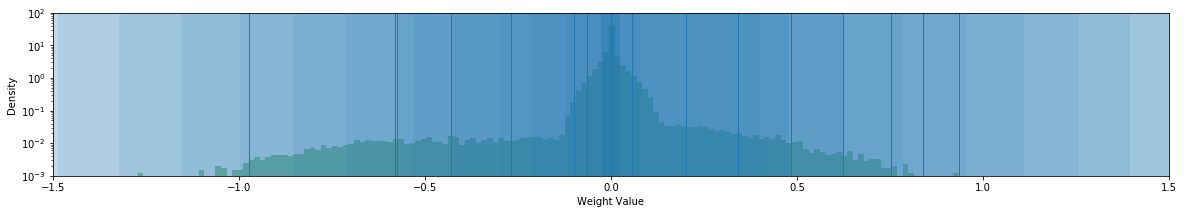

<IPython.core.display.Javascript object>

In [7]:
%%notify
### Using SWS numbers
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, 5, 16, "LeNet_300_100", "full", 'CEST', False)
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 100.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.38, Prune Accuracy: 97.81, Sparsity: 64.60
Epoch: 20. Test Accuracy: 98.03, Prune Accuracy: 96.51, Sparsity: 85.40
Epoch: 30. Test Accuracy: 98.12, Prune Accuracy: 97.88, Sparsity: 95.85
Epoch: 40. Test Accuracy: 98.19, Prune Accuracy: 97.94, Sparsity: 94.77
Epoch: 50. Test Accuracy: 98.16, Prune Accuracy: 97.95, Sparsity: 94.89
Retrain Test: 98.16, Prune Test: 97.95, Prune Sparsity: 94.89


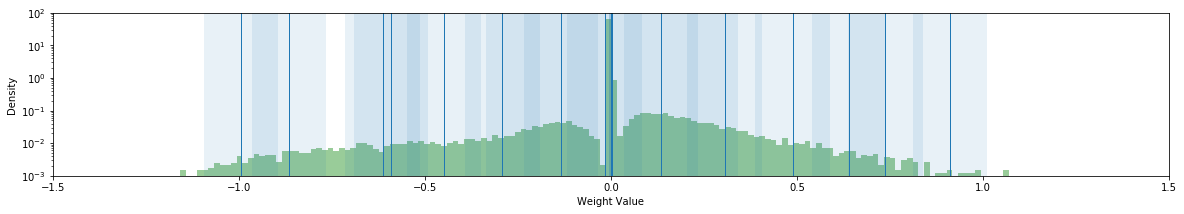

<IPython.core.display.Javascript object>

In [8]:
%%notify
#tuning best result, reduce mean 250 -> 100
model, gmp, res = retrain_model(100, 10, 2500, 1250, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 500.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.30, Prune Accuracy: 97.91, Sparsity: 66.74
Epoch: 20. Test Accuracy: 98.31, Prune Accuracy: 96.96, Sparsity: 86.97
Epoch: 30. Test Accuracy: 97.62, Prune Accuracy: 89.31, Sparsity: 98.21
Epoch: 40. Test Accuracy: 97.79, Prune Accuracy: 94.82, Sparsity: 98.21
Epoch: 50. Test Accuracy: 97.70, Prune Accuracy: 95.47, Sparsity: 98.21
Retrain Test: 97.70, Prune Test: 95.47, Prune Sparsity: 98.21


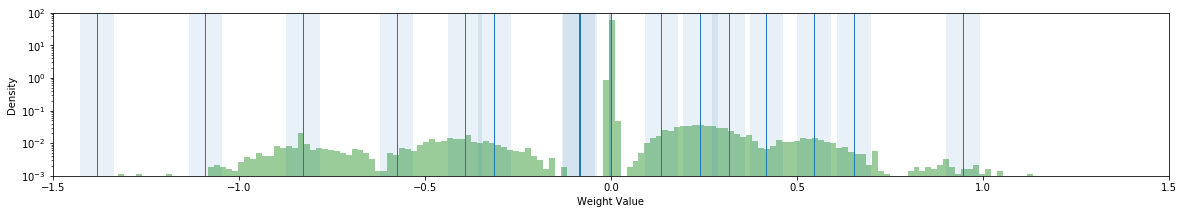

<IPython.core.display.Javascript object>

In [10]:
%%notify
#tuning best result, increase mean 250 -> 500
model, gmp, res = retrain_model(500, 10, 2500, 1250, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 100.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.46, Prune Accuracy: 98.28, Sparsity: 59.78
Epoch: 20. Test Accuracy: 98.45, Prune Accuracy: 98.04, Sparsity: 79.37
Epoch: 30. Test Accuracy: 98.42, Prune Accuracy: 95.59, Sparsity: 89.18
Epoch: 40. Test Accuracy: 98.24, Prune Accuracy: 97.43, Sparsity: 90.93
Epoch: 50. Test Accuracy: 98.23, Prune Accuracy: 97.50, Sparsity: 95.36
Retrain Test: 98.23, Prune Test: 97.50, Prune Sparsity: 95.36


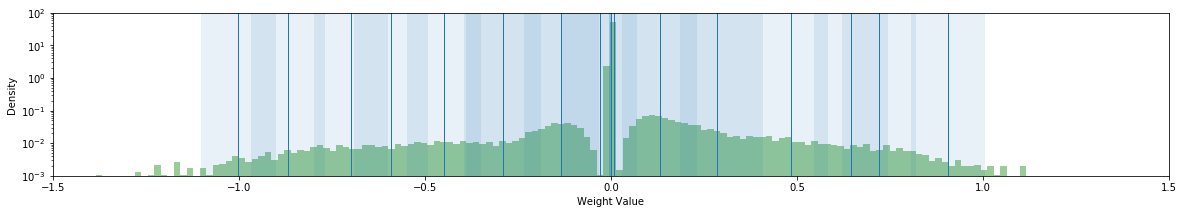

<IPython.core.display.Javascript object>

In [11]:
%%notify
#tuning best result, reduce mean 250 -> 100, increase temp to 8
model, gmp, res = retrain_model(100, 10, 2500, 1250, 1e-5, 8, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 500.0 Variance: 10.0
Epoch: 10. Test Accuracy: 96.59, Prune Accuracy: 95.17, Sparsity: 98.37
Epoch: 20. Test Accuracy: 96.92, Prune Accuracy: 96.04, Sparsity: 98.36
Epoch: 30. Test Accuracy: 97.06, Prune Accuracy: 96.36, Sparsity: 98.36
Epoch: 40. Test Accuracy: 97.26, Prune Accuracy: 96.52, Sparsity: 98.36
Epoch: 50. Test Accuracy: 97.16, Prune Accuracy: 96.43, Sparsity: 98.36
Retrain Test: 97.16, Prune Test: 96.43, Prune Sparsity: 98.36


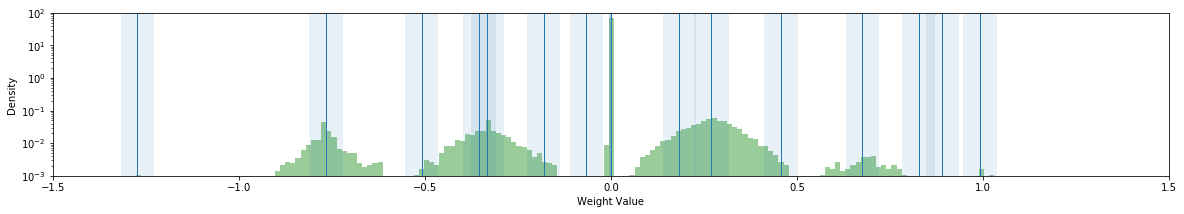

<IPython.core.display.Javascript object>

In [12]:
%%notify
#tuning best result, increase mean 250 -> 500, decrease temp to 2
model, gmp, res = retrain_model(500, 10, 2500, 1250, 1e-5, 2, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 500.0 Variance: 10.0
Epoch: 10. Test Accuracy: 93.18, Prune Accuracy: 72.80, Sparsity: 99.34
Epoch: 20. Test Accuracy: 94.28, Prune Accuracy: 80.15, Sparsity: 98.94
Epoch: 30. Test Accuracy: 94.19, Prune Accuracy: 79.27, Sparsity: 99.36
Epoch: 40. Test Accuracy: 94.32, Prune Accuracy: 80.32, Sparsity: 99.36
Epoch: 50. Test Accuracy: 94.68, Prune Accuracy: 79.22, Sparsity: 99.36
Retrain Test: 94.68, Prune Test: 79.22, Prune Sparsity: 99.36


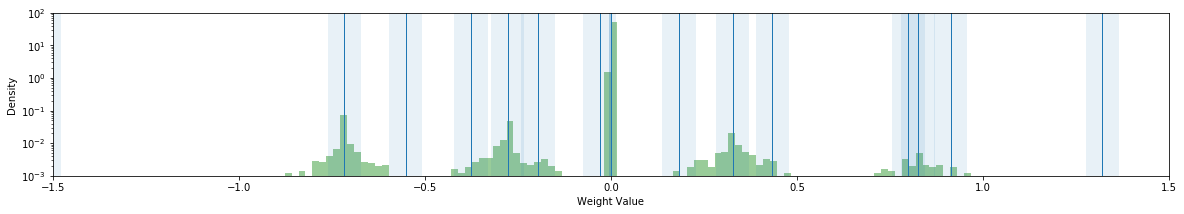

<IPython.core.display.Javascript object>

In [13]:
%%notify
#tuning best result, increase mean 250 -> 500, decrease temp to 2
model, gmp, res = retrain_model(500, 10, 2500, 1250, 1e-5, 1, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 500.0 Variance: 250.0
Non-zero component Mean: 100.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.40, Prune Accuracy: 97.99, Sparsity: 65.89
Epoch: 20. Test Accuracy: 98.19, Prune Accuracy: 95.80, Sparsity: 79.98
Epoch: 30. Test Accuracy: 98.04, Prune Accuracy: 97.90, Sparsity: 95.73
Epoch: 40. Test Accuracy: 98.14, Prune Accuracy: 97.78, Sparsity: 94.78
Epoch: 50. Test Accuracy: 98.13, Prune Accuracy: 97.73, Sparsity: 95.21
Retrain Test: 98.13, Prune Test: 97.73, Prune Sparsity: 95.21


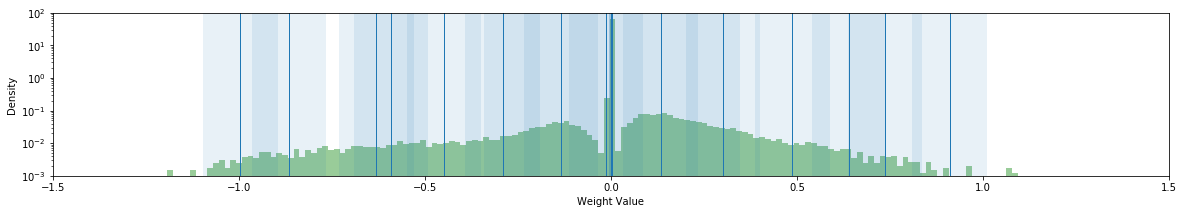

<IPython.core.display.Javascript object>

In [15]:
%%notify
#tuning best result, reduce zmean 2500 -> 500, zvar 1250 -> 250
model, gmp, res = retrain_model(100, 10, 500, 250, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 250.0
Non-zero component Mean: 2000.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.23, Prune Accuracy: 96.29, Sparsity: 79.58
Epoch: 20. Test Accuracy: 98.11, Prune Accuracy: 96.78, Sparsity: 95.26
Epoch: 30. Test Accuracy: 98.03, Prune Accuracy: 96.76, Sparsity: 95.73
Epoch: 40. Test Accuracy: 98.11, Prune Accuracy: 96.78, Sparsity: 95.88
Epoch: 50. Test Accuracy: 98.11, Prune Accuracy: 96.65, Sparsity: 96.00
Retrain Test: 98.11, Prune Test: 96.65, Prune Sparsity: 96.00


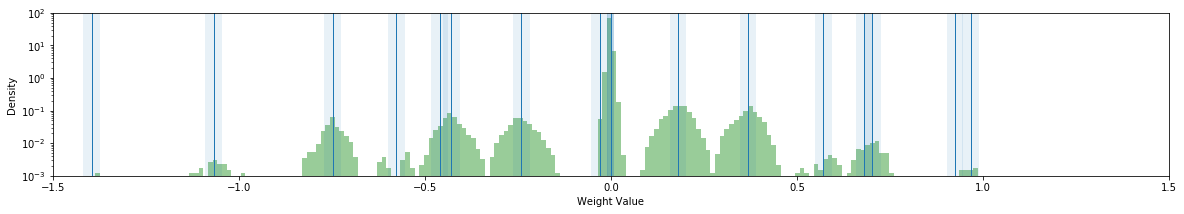

<IPython.core.display.Javascript object>

In [3]:
%%notify
#tuning best result, increase both means
model, gmp, res = retrain_model(2000, 10, 5000, 250, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.30, Prune Accuracy: 92.22, Sparsity: 75.55
Epoch: 20. Test Accuracy: 97.73, Prune Accuracy: 95.30, Sparsity: 85.95
Epoch: 30. Test Accuracy: 98.01, Prune Accuracy: 96.25, Sparsity: 89.36
Epoch: 40. Test Accuracy: 98.05, Prune Accuracy: 96.35, Sparsity: 90.71
Epoch: 50. Test Accuracy: 97.90, Prune Accuracy: 96.70, Sparsity: 91.05
Retrain Test: 97.90, Prune Test: 96.70, Prune Sparsity: 91.05


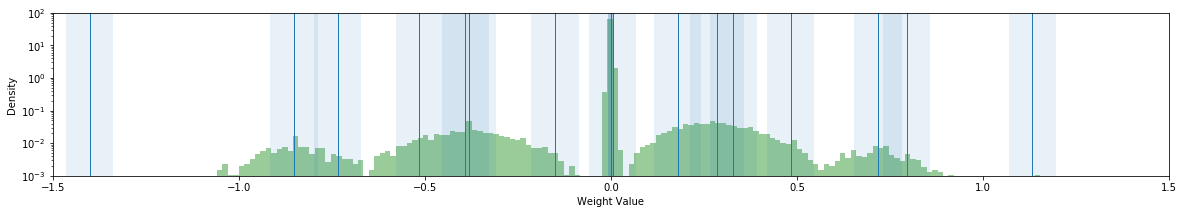

<IPython.core.display.Javascript object>

In [4]:
%%notify
#tuning best result, increase both means
model, gmp, res = retrain_model(250, 10, 2500, 250, 1e-6, 4, 16, "LeNet_300_100", "full", 'MSEST', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

In [12]:
def plot_loss(res):
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(res['epochs'], res['train_loss'][:-1], label = "Complexity Loss", color = 'g')
    p = ax1.plot(res['epochs'], res['train_loss'][:-1], label = "Train Accuracy Loss")
    color = p[0].get_color()
    ax1.plot(res['epochs'], res['test_loss'], label = "Test Accuracy Loss", linestyle = "--", color = color)
    ax1.legend(loc=1)
    ax2.plot(res['epochs'], res['complexity_loss'], label = "Complexity", color = 'g')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy Loss', color=color)
    ax2.set_ylabel('Complexity Loss', color='g')
    plt.show()
    
def plot_acc(res):
    train = plt.plot(res['epochs'], res['train_acc'], label = "Train")
    test = plt.plot(res['epochs'], res['test_acc'], label = "Test")
    plt.legend(ncol=1, fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.show()

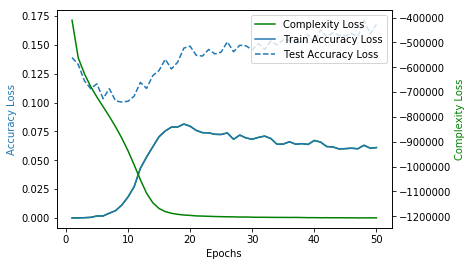

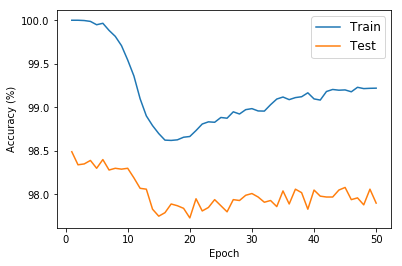

In [13]:
nm = sws_prune_copy(model, gmp)
test_accuracy(test_data_full, test_labels_full, nm)
plot_loss(res)
plot_acc(res)